# Decision Tree

## 1. 基本用法

决策树模型既可以做分类分析（即预测分类变量值），也可以做回归分析（即预测连续变量值），分别对应的模型为分类决策树模型（DecisionTreeClassifier）及回归决策树模型（DecisionTreeRegressor）。

### 1.1 分类决策树模型（DecisionTreeClassifier）

In [2]:
from sklearn.tree import DecisionTreeClassifier
X = [[1, 2], [3, 4], [5, 6], [7, 8], [9, 10]]
y = [1, 0, 0, 1, 1]

model = DecisionTreeClassifier(random_state=0)
model.fit(X, y)

print(model.predict([[5, 5]]))

[0]


### 1.2 回归决策树模型（DecisionTreeRegressor）

In [3]:
from sklearn.tree import DecisionTreeRegressor
X = [[1, 2], [3, 4], [5, 6], [7, 8], [9, 10]]
y = [1, 2, 3, 4, 5]

model = DecisionTreeRegressor(max_depth=2, random_state=0)
model.fit(X, y)

print(model.predict([[9, 9]]))

[4.5]


## 2. 案例：预测糖尿病  
数据源: https://www.kaggle.com/uciml/pima-indians-diabetes-database#diabetes.csv

### 2.1 分析数据

In [13]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [5]:
# 读入数据(bp: BloodPressure, st: SkinThickness, pedigree: DiabetesPedigreeFunction)
col_names = ['pregnant', 'glucose', 'bp', 'st', 'insulin', 'bmi', 'pedigree', 'age', 'label']
pima = pd.read_csv("pima-indians-diabetes.csv", header=None, names=col_names)
pima

,pregnant,glucose,bp,st,insulin,bmi,pedigree,age,label
0,6,148,72,35,0,33.6,0.627,50,1
1,1,85,66,29,0,26.6,0.351,31,0
2,8,183,64,0,0,23.3,0.672,32,1
3,1,89,66,23,94,28.1,0.167,21,0
4,0,137,40,35,168,43.1,2.288,33,1
...,...,...,...,...,...,...,...,...,...
763,10,101,76,48,180,32.9,0.171,63,0
764,2,122,70,27,0,36.8,0.340,27,0
765,5,121,72,23,112,26.2,0.245,30,0
766,1,126,60,0,0,30.1,0.349,47,1


In [18]:
# 特征和标签
X = pima[['pregnant', 'glucose', 'bp', 'st', 'insulin', 'bmi', 'pedigree', 'age']]
y = pima['label']

In [23]:
# 空值检测 
X.isnull().sum()

pregnant    0
glucose     0
bp          0
st          0
insulin     0
bmi         0
pedigree    0
age         0
dtype: int64

结论：无缺失值

**相关性分析**

,pregnant,glucose,bp,st,insulin,bmi,pedigree,age
pregnant,1.000000,0.129459,0.141282,-0.081672,-0.073535,0.017683,-0.033523,0.544341
glucose,0.129459,1.000000,0.152590,0.057328,0.331357,0.221071,0.137337,0.263514
bp,0.141282,0.152590,1.000000,0.207371,0.088933,0.281805,0.041265,0.239528
st,-0.081672,0.057328,0.207371,1.000000,0.436783,0.392573,0.183928,-0.113970
insulin,-0.073535,0.331357,0.088933,0.436783,1.000000,0.197859,0.185071,-0.042163
bmi,0.017683,0.221071,0.281805,0.392573,0.197859,1.000000,0.140647,0.036242
pedigree,-0.033523,0.137337,0.041265,0.183928,0.185071,0.140647,1.000000,0.033561
age,0.544341,0.263514,0.239528,-0.113970,-0.042163,0.036242,0.033561,1.000000


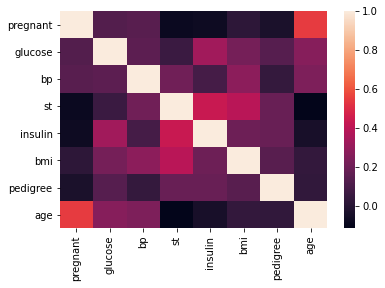

In [22]:
corr = X.corr()
sns.heatmap(corr, 
            xticklabels=corr.columns.values,
            yticklabels=corr.columns.values)
corr

除怀孕次数与年龄的相关性稍强，其余的特征之间的相关性很弱。

**概率密度函数**

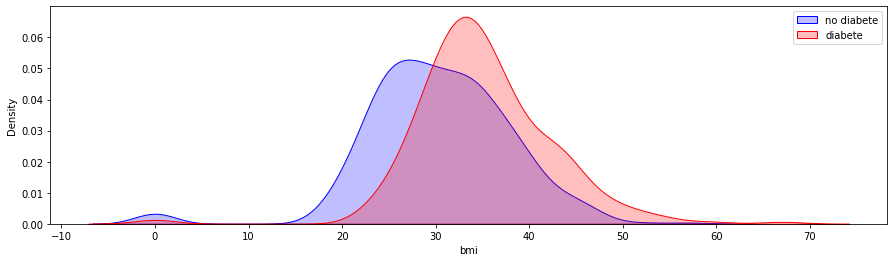

In [33]:
# 查看BMI与糖尿病的关系（概率密度函数）
fig = plt.figure(figsize=(15,4))
ax = sns.kdeplot(pima.loc[(pima['label'] == 0),'bmi'] , color='b',shade=True, label='no diabete')
ax = sns.kdeplot(pima.loc[(pima['label'] == 1),'bmi'] , color='r',shade=True, label='diabete')
ax.legend(loc="upper right")

**T检验**

In [48]:
# 求均值
bmi_dia = pima[pima['label']==1]['bmi'].mean()
bmi_no_dia = pima[pima['label']==0]['bmi'].mean()

print('糖尿病患者BMI均值:{}'.format(bmi_dia))
print('非糖尿病患者BMI均值:{}'.format(bmi_no_dia))

糖尿病患者BMI均值:35.14253731343278
非糖尿病患者BMI均值:30.30419999999996


In [49]:
# 进行T检验
import scipy.stats as stats
stats.ttest_1samp(a = pima[pima['label']==1]['bmi'], # 糖尿病患者BMI样本
                  popmean = bmi_no_dia)  # '非糖尿病患者BMI均值

Ttest_1sampResult(statistic=10.905597235481245, pvalue=3.80527995461745e-23)

P值小于0.05，表明在统计学意义上，患糖尿病的患者BMI指数和非糖尿病患者的BMI指数有显著性差异，且BMI指数越高，越有可能患有糖尿病（但是二者之间的因果关系不能确定）。

### 2.2 构建模型

In [34]:
# 导入数据包
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split
from sklearn import metrics 

In [35]:
# 将数据分为训练和测试数据
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1)

In [55]:
# 创建决策树分类器
clf = DecisionTreeClassifier(criterion='entropy',random_state=0)

# 训练模型
clf = clf.fit(X_train,y_train)

# 使用训练好的模型做预测
y_pred = clf.predict(X_test)

In [56]:
# 模型的准确性
print("Accuracy:",metrics.accuracy_score(y_test, y_pred))

Accuracy: 0.6753246753246753


### 2.3 模型调优

下面是分类决策树模型DecisionTreeClassifier()模型常用的一些超参数及它们的解释：
1. criterion：特征选择标准，取值为"entropy"信息熵和"gini"基尼系数，默认选择"gini"。
2. splitter：取值为"best"和"random"，"best"在特征的所有划分点中找出最优的划分点，适合样本量不大的情况，"random"随机地在部分划分点中找局部最优的划分点，适合样本量非常大的情况，默认选择"best"。
3. max_depth：决策树最大深度，取值为int或None，一般数据或特征比较少的时候可以不设置，如果数据或特征比较多时，可以设置最大深度进行限制。默认取‘None’。
4. min_samples_split：子节点往下划分所需的最小样本数，默认取2，如果子节点中的样本数小于该值则停止分裂。
5. min_samples_leaf：叶子节点的最少样本数，默认取1，如果小于该数值，该叶子节点会和兄弟节点一起被剪枝（即剔除该叶子节点和其兄弟节点，并停止分裂）。
6. min_weight_fraction_leaf：叶子节点最小的样本权重和，默认取0，即不考虑权重问题，如果小于该数值，该叶子节点会和兄弟节点一起被剪枝（即剔除该叶子节点和其兄弟节点，并停止分裂）。如果较多样本有缺失值或者样本的分布类别偏差很大，则需考虑样本权重问题。
7. max_features：在划分节点时所考虑的特征值数量的最大值，默认取None，可以传入int型或float型数据。如果是float型数据，表示百分数。
8. max_leaf_nodes：最大叶子节点数，默认取None，可以传入int型数据。
9. class_weight：指定类别权重，默认取None，可以取"balanced"，代表样本量少的类别所对应的样本权重更高，也可以传入字典指定权重。该参数主要是为防止训练集某些类别的样本过多，导致训练的决策树过于偏向这些类别。除了此处指定class_weight，还可以使用过采样和欠采样的方法处理样本类别不平衡的问题。
10. random_state：当数据量较大，或特征变量较多时，可能在某个节点划分时，会碰上两个特征变量的信息熵增益或者基尼系数减少量是一样的情况，那么此时决策树模型默认是随机从中选一个特征变量进行划分，这样可能会导致每次运行程序后生成的决策树不太一致。如果设定random_state参数（如设置为123）可以保证每次运行代码时，各个节点的分裂结果都是一致的，这在特征变量较多，树的深度较深的时候较为重要。

In [52]:
from sklearn.model_selection import GridSearchCV

# 指定决策树分类器中各个参数的范围
parameters = {'max_depth': [3, 5, 7, 9, 11, 13], 'criterion':['gini', 'entropy'], 'min_samples_split':[5, 7, 9, 11, 13, 15], 'max_features':[4, 5, 6, 7, 8]}
# 构建决策树分类器
model = DecisionTreeClassifier() 

# 网格搜索
grid_search = GridSearchCV(model, parameters, scoring='accuracy', cv=5)
grid_search.fit(X_train, y_train)

# 获得参数的最优值
grid_search.best_params_

{'criterion': 'entropy',
 'max_depth': 3,
 'max_features': 6,
 'min_samples_split': 9}

In [58]:
# 根据多参数调优的结果来重新搭建模型
model = DecisionTreeClassifier(criterion='entropy', max_depth=3, min_samples_split=9, max_features=6, random_state=0)
model.fit(X_train, y_train) 

# 查看整体预测准确度
y_pred = model.predict(X_test)
from sklearn.metrics import accuracy_score
score = accuracy_score(y_pred, y_test)
print(score)

0.7987012987012987


准确率得到有效提升